In [1]:
import pvlib
import pandas as pd 
import matplotlib.pyplot as plt

In [2]:
# Set Location Class
location = pvlib.location.Location(latitude = 37.978136, longitude = -121.312537, name = 'Lot 4', altitude = 6, tz = 'Etc/GMT+7')

# Set Array Mounting Class
mount = [
    pvlib.pvsystem.FixedMount(surface_tilt = 7, surface_azimuth= 162),
    pvlib.pvsystem.FixedMount(surface_tilt = 7, surface_azimuth= 252),
    pvlib.pvsystem.FixedMount(surface_tilt = 7, surface_azimuth= 135),
    pvlib.pvsystem.FixedMount(surface_tilt = 7, surface_azimuth= 137),
    pvlib.pvsystem.FixedMount(surface_tilt = 7, surface_azimuth= 139),
    pvlib.pvsystem.FixedMount(surface_tilt = 7, surface_azimuth= 118)   
]

In [3]:
# Get the cec_modules and inverters databases
SAM_URL = "CEC Modules.csv"
cec_modules = pvlib.pvsystem.retrieve_sam(path=SAM_URL) 
cec_modules = cec_modules.drop('Manufacturer', axis=0)
cec_modules = cec_modules.loc[:, ~cec_modules.columns.duplicated()]
cec_inverters = pvlib.pvsystem.retrieve_sam('cecinverter')

# get the module and inverter specifications
module_parameters = cec_modules['Hanwha_Q_CELLS_Q_PEAK_DUO_L_G6_3_425']
inverter_parameters = cec_inverters['Huawei_Technologies_Co___Ltd___SUN2000_40KTL_US__480V_']

num_inverters = 12

FileNotFoundError: [Errno 2] No such file or directory: 'CEC Modules.csv'

In [61]:
inverter_parameters.Vdco = 1000
inverter_parameters.Vdcmax = 1000
inverter_parameters.Idcmax = 88
inverter_parameters.Mppt_high = 1000
inverter_parameters.Mppt_low = 200
inverter_parameters.Paco = 36600.0
inverter_parameters

Vac                   480
Pso             56.863487
Paco              36600.0
Pdco         40648.484375
Vdco                 1000
C0                   -0.0
C1              -0.000018
C2              -0.002095
C3               -0.00391
Pnt                  12.0
Vdcmax               1000
Idcmax                 88
Mppt_low              200
Mppt_high            1000
CEC_Date       10/15/2018
CEC_Type     Grid Support
Name: Huawei_Technologies_Co___Ltd___SUN2000_40KTL_US__480V_, dtype: object

In [62]:
# set the temperature model parameters
temperature_model_parameters = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass']

In [63]:
# set the system array class
array = [
    pvlib.pvsystem.Array(mount[0], module_parameters=module_parameters, modules_per_string=18.5, temperature_model_parameters=temperature_model_parameters, strings=6),
    pvlib.pvsystem.Array(mount[0], module_parameters=module_parameters, modules_per_string=18, temperature_model_parameters=temperature_model_parameters, strings=7)
]

In [64]:
# set the PV System class
losses_parameters = dict(shading=0, availability=0)

system = [
    pvlib.pvsystem.PVSystem(array[0], inverter_parameters=inverter_parameters, losses_parameters=losses_parameters),
    pvlib.pvsystem.PVSystem(array[1], inverter_parameters=inverter_parameters, losses_parameters=losses_parameters)
]

In [65]:
mc = [
    pvlib.modelchain.ModelChain(system[0], location, aoi_model='physical', spectral_model='no_loss'), # losses_model='pvwatts'
    pvlib.modelchain.ModelChain(system[1], location, aoi_model='physical', spectral_model='no_loss') #  losses_model='pvwatts'
]

In [66]:
times = pd.date_range('07-01-2023', freq='15min', periods=4*24, tz=location. tz)
clearsky = location.get_clearsky(times)

In [67]:
mc[0].run_model(clearsky)
mc[1].run_model(clearsky)

ModelChain: 
  name: None
  clearsky_model: ineichen
  transposition_model: haydavies
  solar_position_method: nrel_numpy
  airmass_model: kastenyoung1989
  dc_model: cec
  ac_model: sandia_inverter
  aoi_model: physical_aoi_loss
  spectral_model: no_spectral_loss
  temperature_model: sapm_temp
  losses_model: no_extra_losses

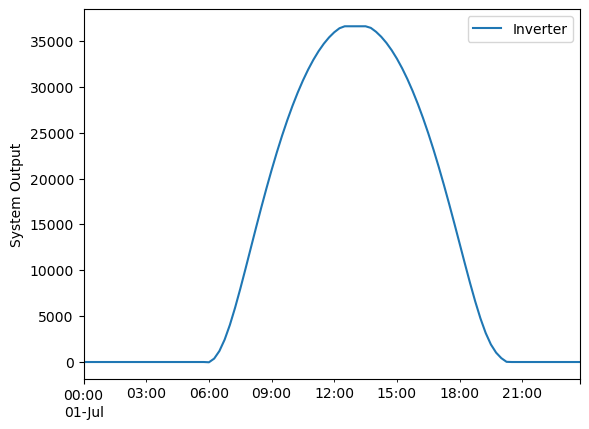

In [68]:
mc[0].results.ac.plot(label='Inverter')
plt.ylabel('System Output')
plt.legend()
plt.show()


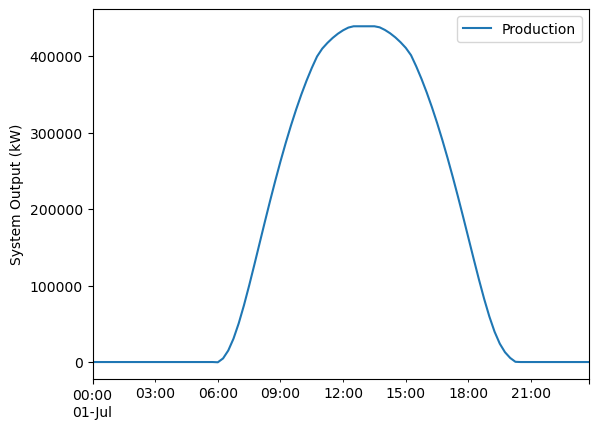

In [69]:
prod = 8*mc[0].results.ac + 4*mc[1].results.ac
prod.plot(label='Production')
plt.ylabel('System Output (kW)')
plt.legend()
plt.show()

In [70]:
prod.to_csv('pvlib_july1.csv')

In [71]:
# Fetch weather data
# ------------------
# Use weather data taken from the NSRDB PSM3 for the year
# 2023.

# api_key = 'lNchMCSOEzggsbHeDy7kCAkg9VC0UrUJEVyx0uFZ'
# email = 'dmueller@pacific.edu'

# keys = ['ghi', 'dni', 'dhi', 'temp_air', 'wind_speed',
#         'albedo', 'precipitable_water']

# psm3, psm3_metadata = pvlib.iotools.get_psm3(
#     latitude, 
#     longitude, 
#     api_key,
#     email, 
#     interval=15, 
#     names=2022,                                         
#     map_variables=True, 
#     leap_day=True,
#     attributes=keys
# )